In [1]:
# 라이브러리
import os
import pandas as pd
import numpy as np
import missingno as mn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import product

# 지도 라이브러리
import folium 
from folium.plugins import MarkerCluster, FeatureGroupSubGroup

In [2]:
# 라이브러리 옵션
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('precision', 6)

warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['lines.linewidth'] = 2

In [3]:
# 데이터 불러오기
train_path = os.path.join('data','train.csv')
test_path = os.path.join('data','test.csv')
sub_path = os.path.join('data','sample_submission.csv')

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(sub_path)

# 데이터 정보
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 
21. sqft_lot15 : 

# 데이터 탐색

In [4]:
# data shape
train.shape, test.shape

((15035, 21), (6468, 20))

In [5]:
# data info
# train 과 test는 y값만 다름
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [6]:
# 필요없는 column 삭제
train.drop('id',axis=1, inplace=True)
test.drop('id',axis=1, inplace=True)

In [7]:
# y column 확인
set(train.columns) - set(test.columns)

{'price'}

In [8]:
# y 저장
y = train['price']
# train, test 복사 / 혹시 모를 실수 대비
train_copy = train.copy()
test.copy = test.copy()

train.drop('price' , axis=1, inplace=True)

In [9]:
# train head
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [9]:
# 기술통계량 확인
print('train set')
display(train.describe())
print('test set')
display(test.describe())

train set


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


test set


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,6468.00000,6468.000000,6468.000000,6.468000e+03,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000
mean,3.37786,2.118313,2075.981293,1.469916e+04,1.488327,0.008658,0.235467,3.416821,7.655535,1779.556277,296.425015,1970.949443,86.933983,98077.587044,47.558726,-122.214039,1974.429654,12659.800402
std,0.99064,0.775851,910.613001,3.870428e+04,0.544007,0.092652,0.773616,0.658267,1.161900,820.834051,447.218709,29.292377,407.210870,53.936590,0.139659,0.139766,671.597761,26380.422371
min,0.00000,0.000000,370.000000,6.810000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.159300,-122.512000,460.000000,748.000000
25%,3.00000,1.750000,1420.000000,5.084000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98032.000000,47.467175,-122.327000,1480.000000,5100.000000
50%,3.00000,2.250000,1920.000000,7.607000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1550.000000,0.000000,1975.000000,0.000000,98065.000000,47.572150,-122.229000,1820.000000,7664.500000
75%,4.00000,2.500000,2520.000000,1.066425e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2190.000000,590.000000,1997.000000,0.000000,98118.000000,47.677400,-122.123000,2370.000000,10125.000000
max,33.00000,6.750000,9640.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8020.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.364000,5610.000000,438213.000000


<AxesSubplot:>

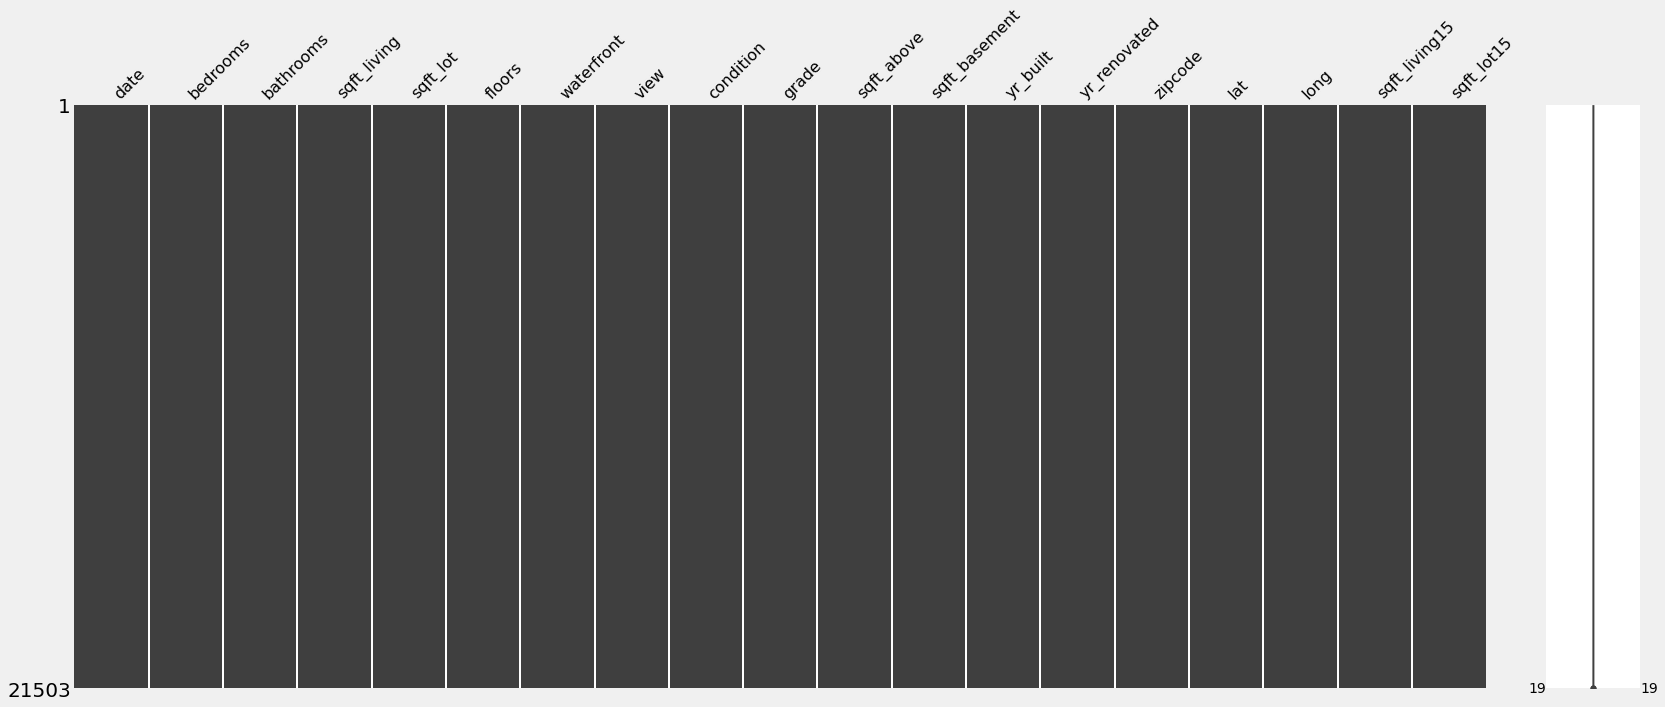

In [10]:
# Na check
mn.matrix(pd.concat([train,test]))

In [11]:
# Na check
pd.concat([train,test]).isna().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [12]:
# train, test length
train_len = train.shape[0]
test_len = test.shape[0]

In [13]:
# date concat
# date - 년월 표시 변경
train['date'] = train['date'].map(lambda x : x[:6])
test['date'] = test['date'].map(lambda x : x[:6])

In [14]:
# train , test concat
total_data = pd.concat([train, test])

In [15]:
# column 별 unique값 확인 - 범주형, 연속형 변수를 골라내기 위함
cat_col = []
con_col = []
for col in total_data.columns:
    print('col : {} '.format(col))
    print('*'*50)
    print('{}의 unique 수 : {}'.format(col,total_data[col].nunique()))
    print()
    if total_data[col].nunique() < 100:
        cat_col.append(col)
    else:
        con_col.append(col)

col : date 
**************************************************
date의 unique 수 : 13

col : bedrooms 
**************************************************
bedrooms의 unique 수 : 13

col : bathrooms 
**************************************************
bathrooms의 unique 수 : 30

col : sqft_living 
**************************************************
sqft_living의 unique 수 : 1038

col : sqft_lot 
**************************************************
sqft_lot의 unique 수 : 9782

col : floors 
**************************************************
floors의 unique 수 : 6

col : waterfront 
**************************************************
waterfront의 unique 수 : 2

col : view 
**************************************************
view의 unique 수 : 5

col : condition 
**************************************************
condition의 unique 수 : 5

col : grade 
**************************************************
grade의 unique 수 : 12

col : sqft_above 
**************************************************
sqft_above의 unique 수 : 

In [16]:
for col in cat_col:
    print('col : {} '.format(col))
    print('*'*50)
    print('{}의 unique: \n{}'.format(col,total_data[col].unique()))
    print()

col : date 
**************************************************
date의 unique: 
['201410' '201502' '201406' '201501' '201504' '201405' '201503' '201407'
 '201412' '201408' '201411' '201409' '201505']

col : bedrooms 
**************************************************
bedrooms의 unique: 
[ 3  2  5  4  6  1  7  9  8  0 10 11 33]

col : bathrooms 
**************************************************
bathrooms의 unique: 
[1.   2.   2.25 1.5  2.5  1.75 3.   2.75 3.25 4.   3.5  0.75 4.75 5.
 4.25 4.5  3.75 5.25 6.   1.25 0.5  5.5  6.75 5.75 0.   8.   7.5  7.75
 6.25 6.5 ]

col : floors 
**************************************************
floors의 unique: 
[1.  2.  1.5 3.  2.5 3.5]

col : waterfront 
**************************************************
waterfront의 unique: 
[0 1]

col : view 
**************************************************
view의 unique: 
[0 3 4 2 1]

col : condition 
**************************************************
condition의 unique: 
[3 4 5 2 1]

col : grade 
*********************

# 시각화

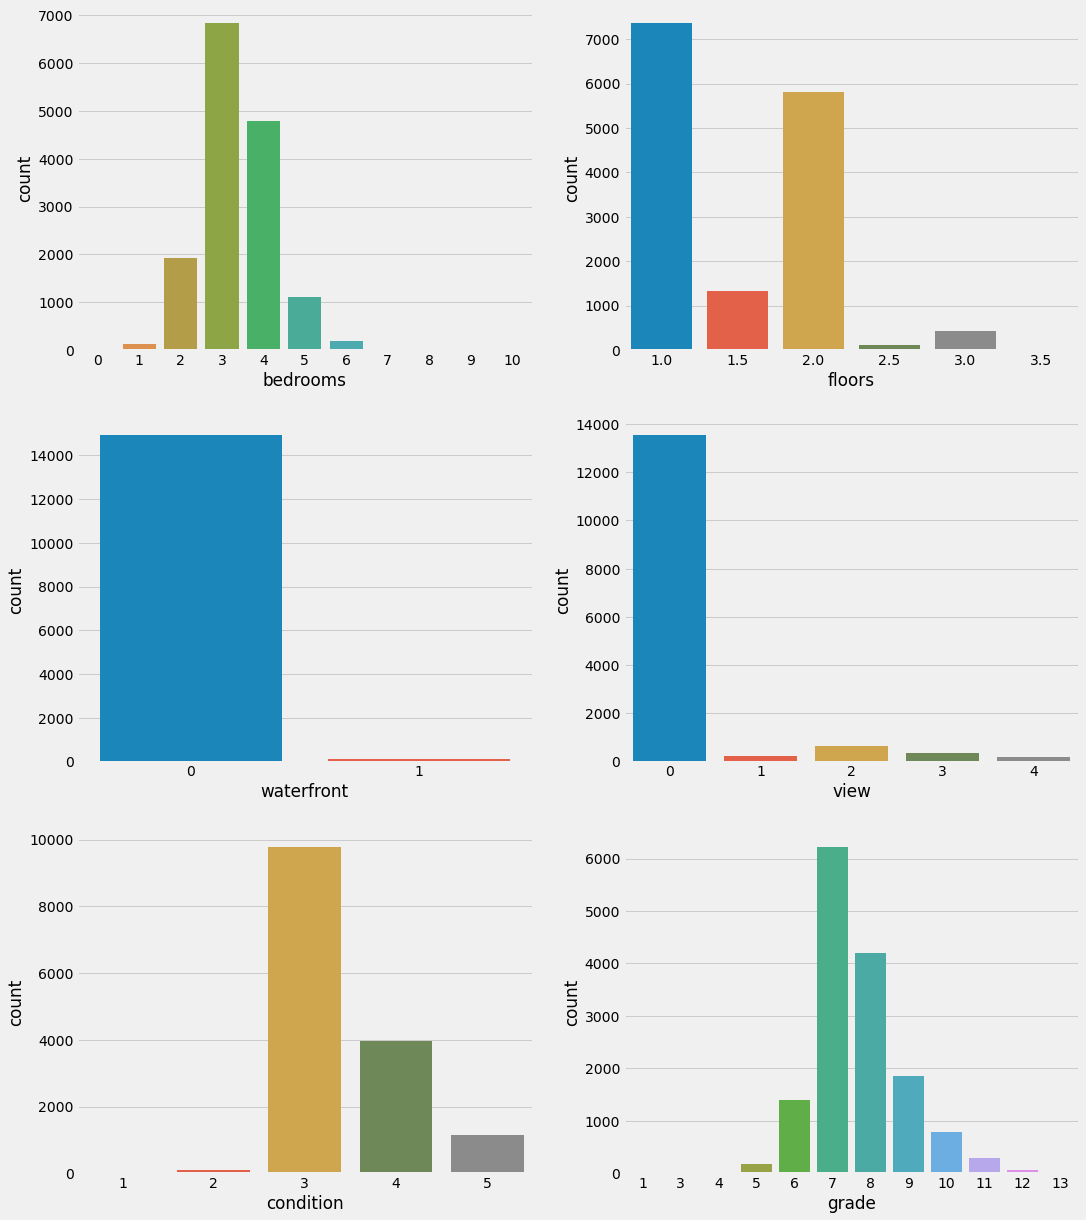

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(16, 20))
row = list(range(3))
col = list(range(2))
iters = product(row,col)
cat_col2 = ['bedrooms','floors','waterfront','view','condition','grade']
for col, i in zip(cat_col2, iters):
    sns.countplot(train[col], ax = ax[i[0]][i[1]])

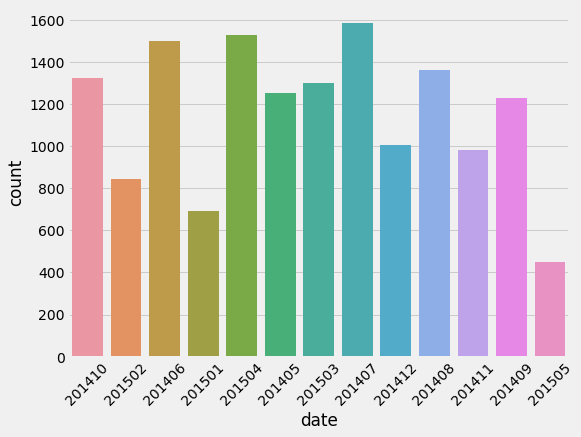

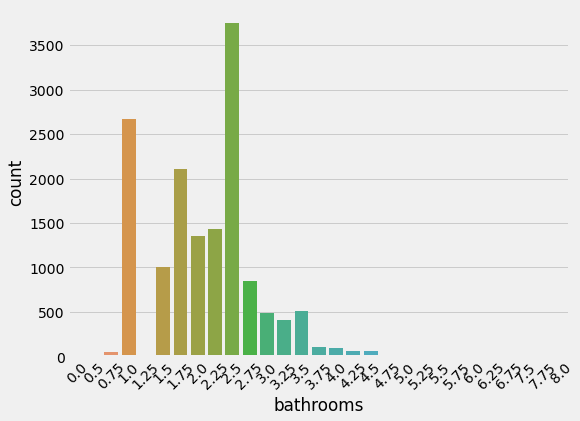

In [18]:
for col in ['date', 'bathrooms']:
    sns.countplot(train[col])
    plt.xticks(rotation=45)
    plt.show()

<AxesSubplot:xlabel='price', ylabel='date'>

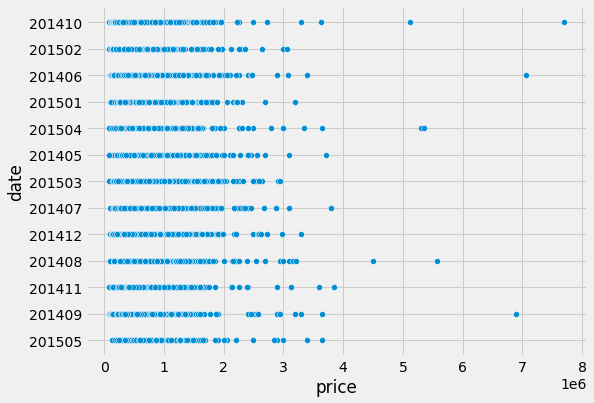

In [19]:
sns.scatterplot(y=train['date'], x=y)

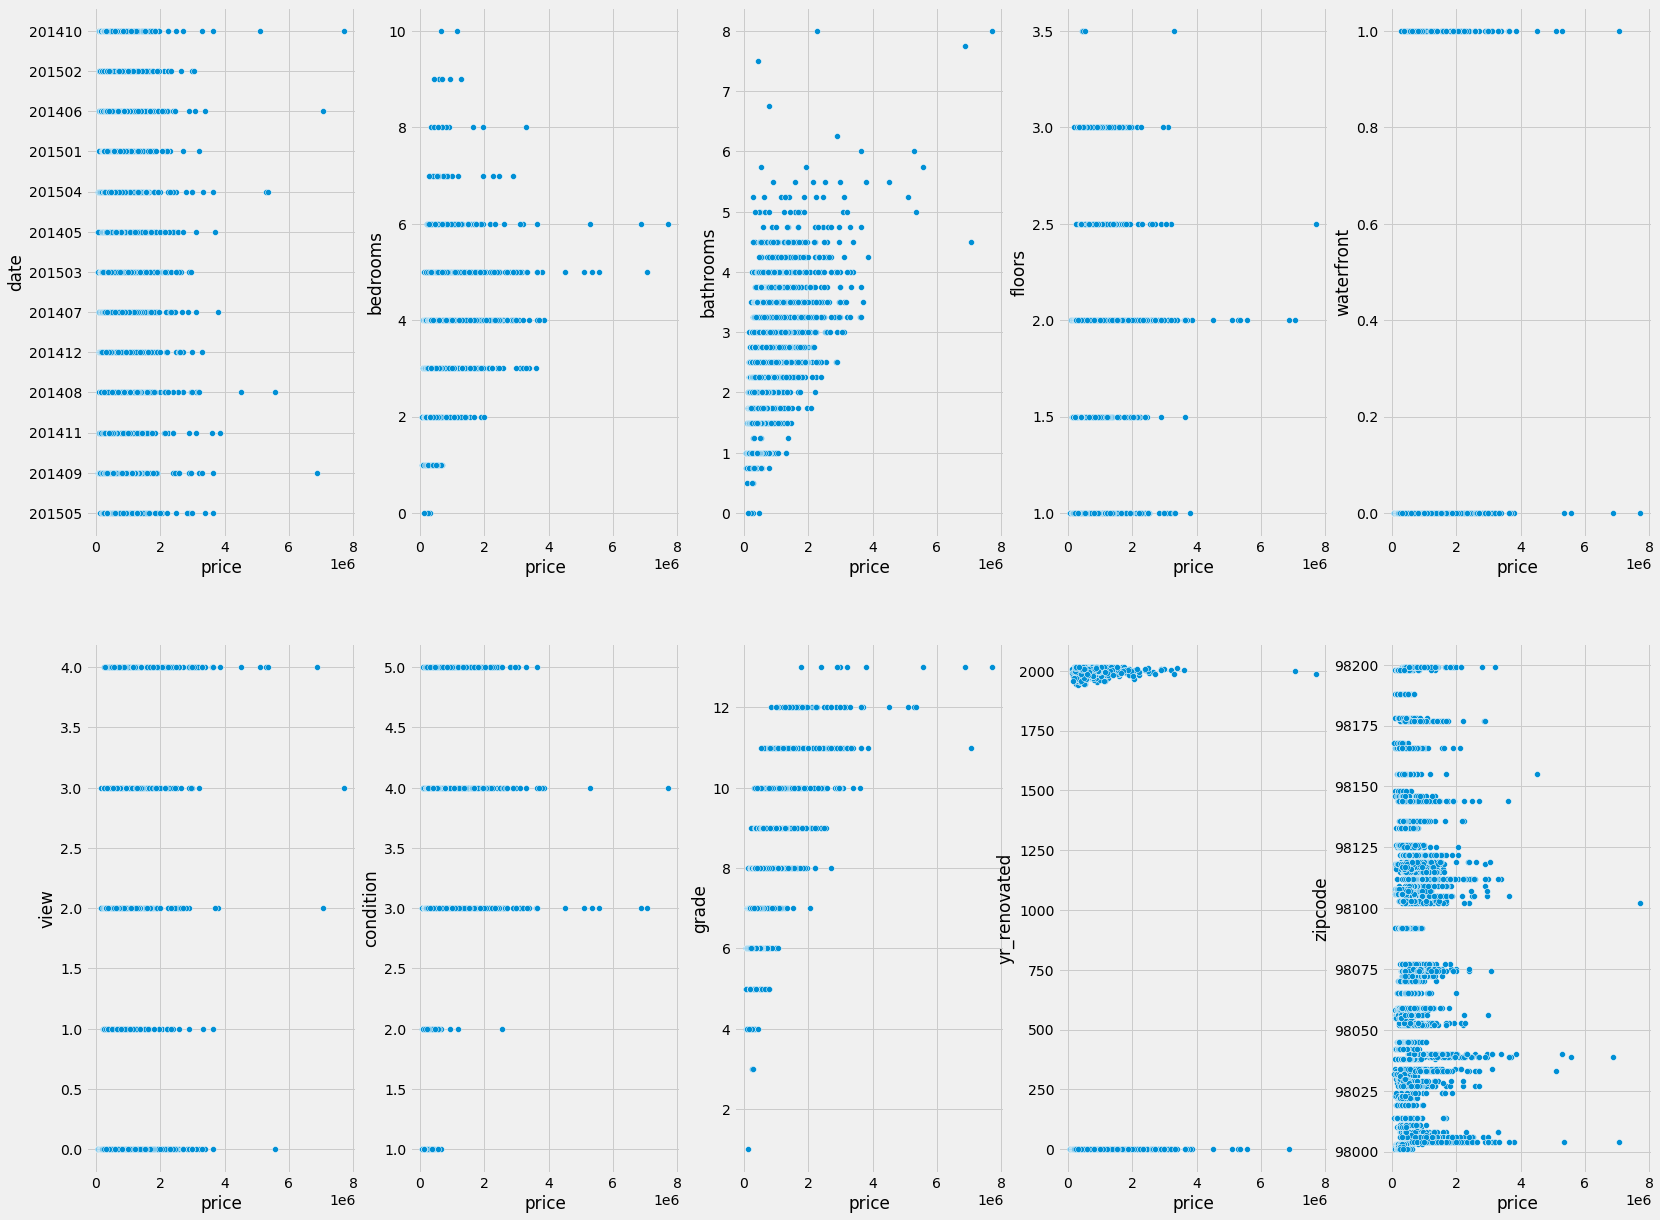

In [20]:
# y 값과 cat_col 관계
fig, ax = plt.subplots(2, 5, figsize=(25, 20))
row = list(range(2))
col = list(range(5))
iters = product(row,col)
for col, i in zip(cat_col, iters):
    sns.scatterplot(y = train[col], x=y, ax =ax[i[0]][i[1]])

col : sqft_living 
**************************************************


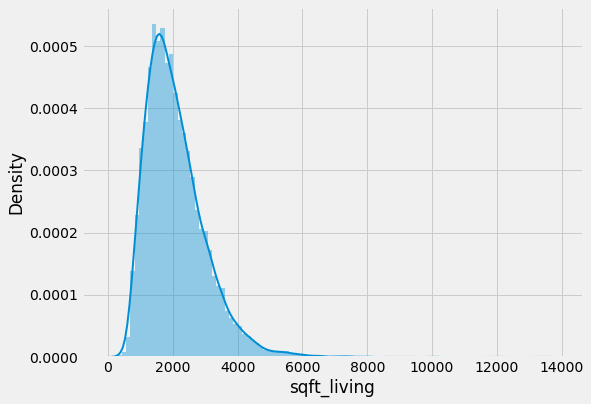

col : sqft_lot 
**************************************************


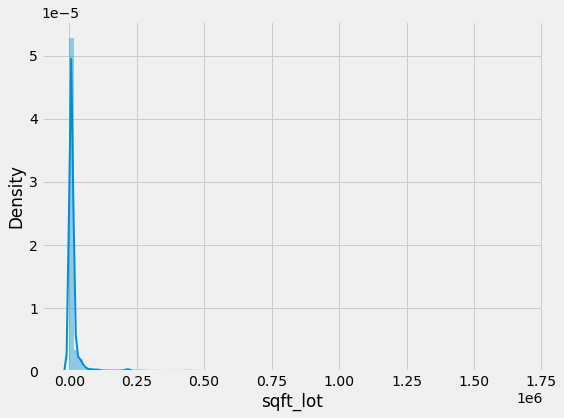

col : sqft_above 
**************************************************


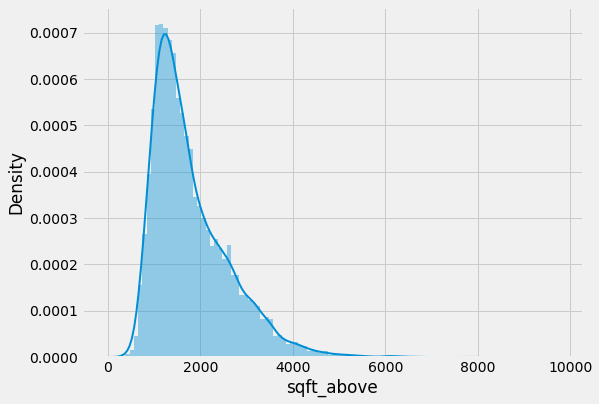

col : sqft_basement 
**************************************************


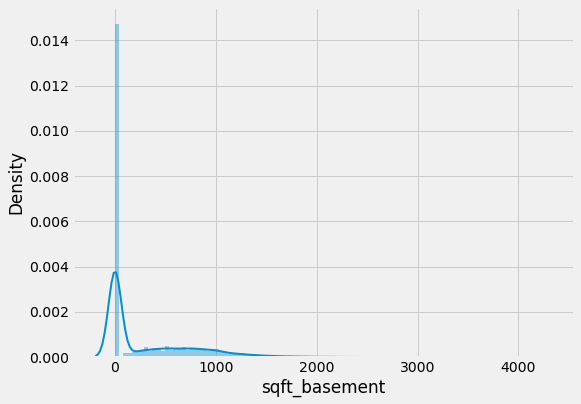

col : yr_built 
**************************************************


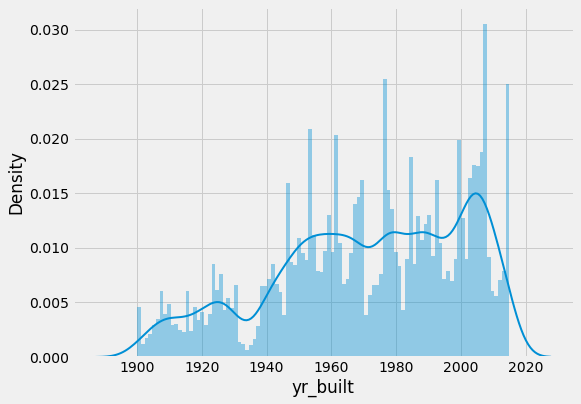

col : lat 
**************************************************


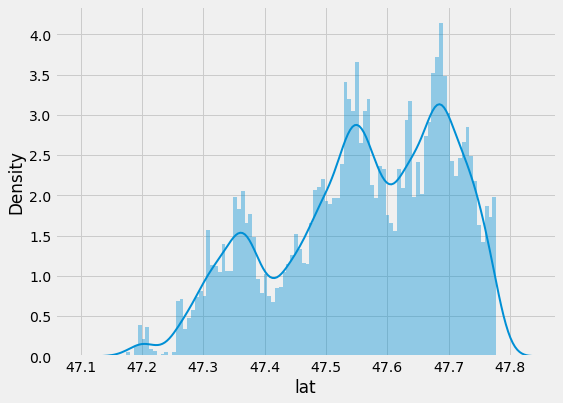

col : long 
**************************************************


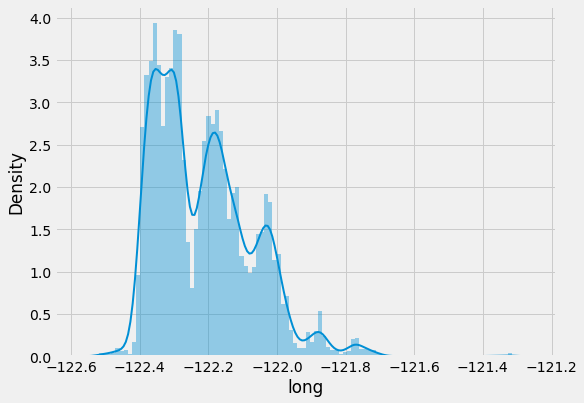

col : sqft_living15 
**************************************************


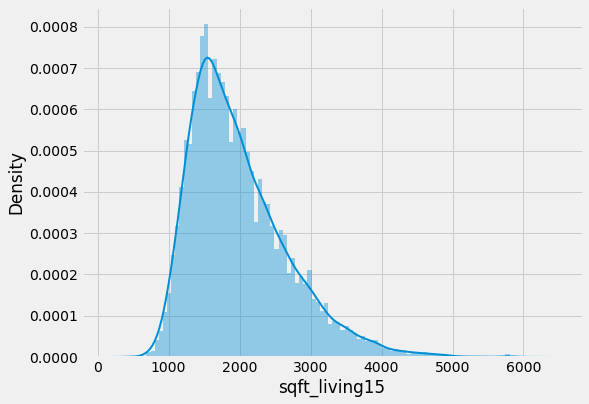

col : sqft_lot15 
**************************************************


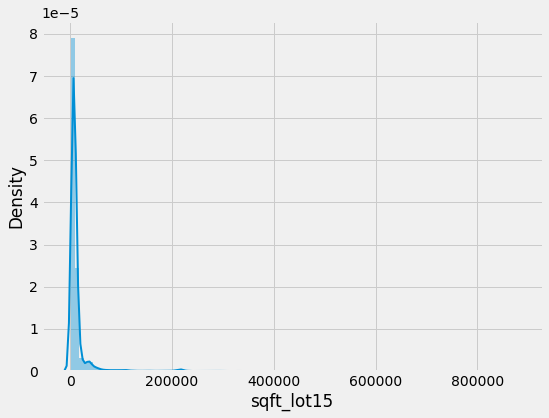

In [21]:
# 연속형 변수 분포
for col in con_col:
    print('col : {} '.format(col))
    print('*'*50)
    sns.distplot(train[col], bins=100)
    plt.show()

<AxesSubplot:>

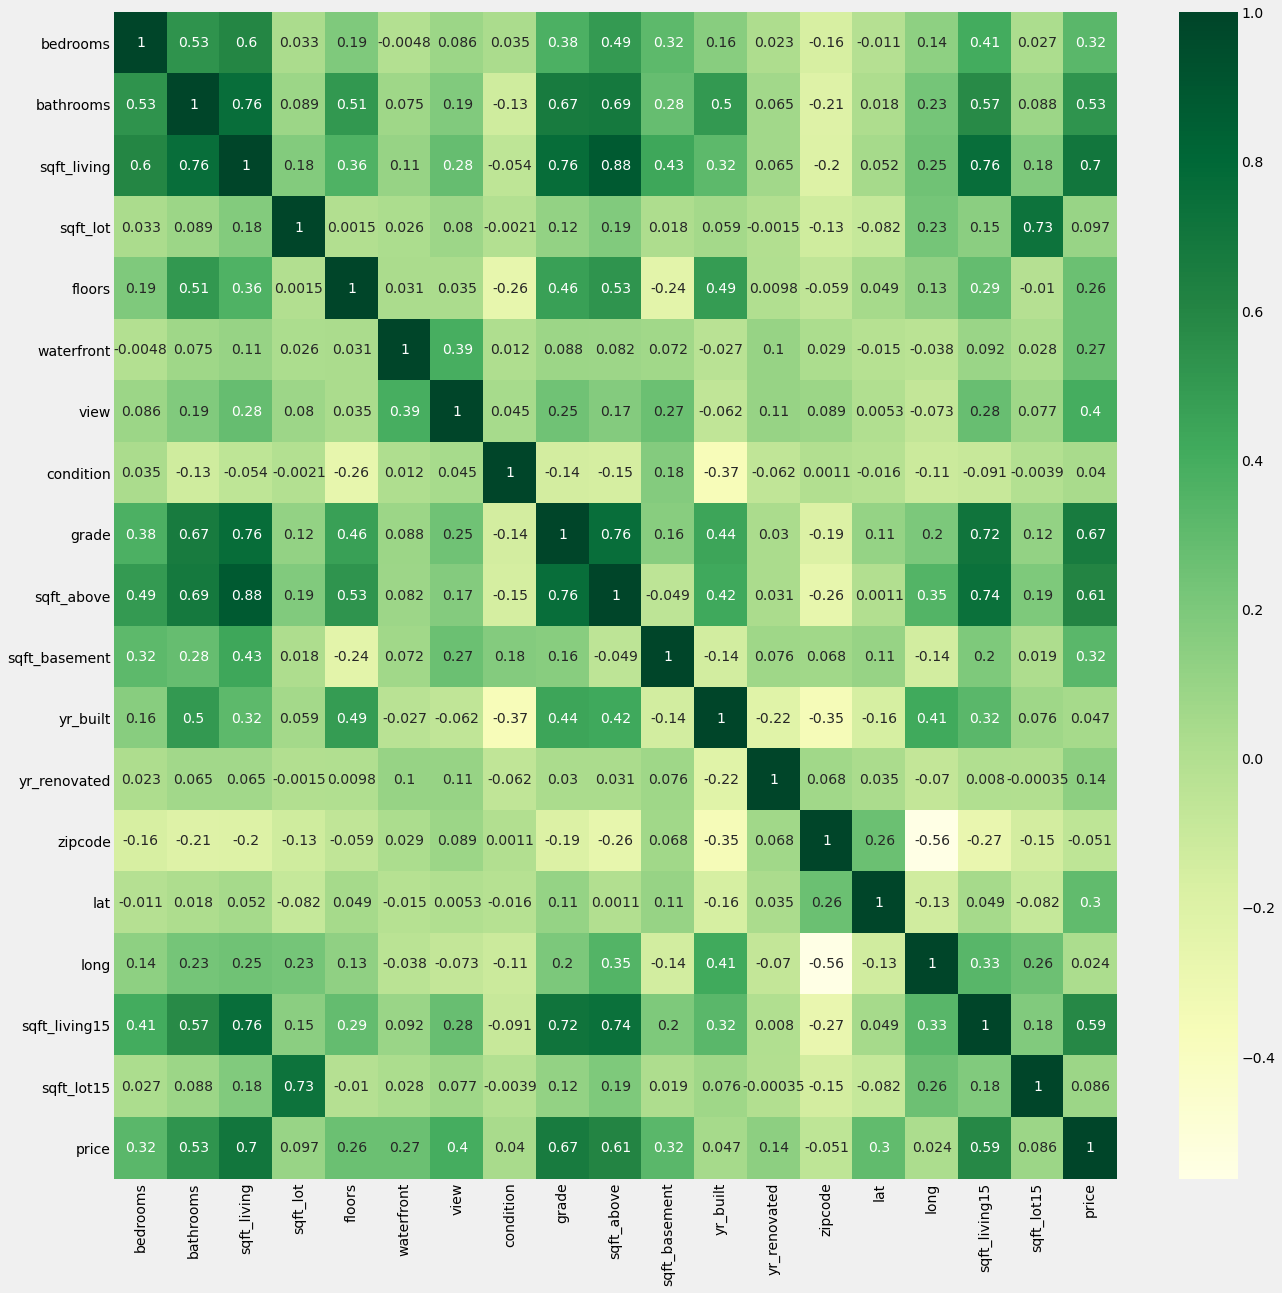

In [22]:
# 상관계수 heatamap
plt.figure(figsize=(20,20))
cor = pd.concat([train, y], axis=1).corr()
sns.heatmap(cor,annot=True ,cmap='YlGn')

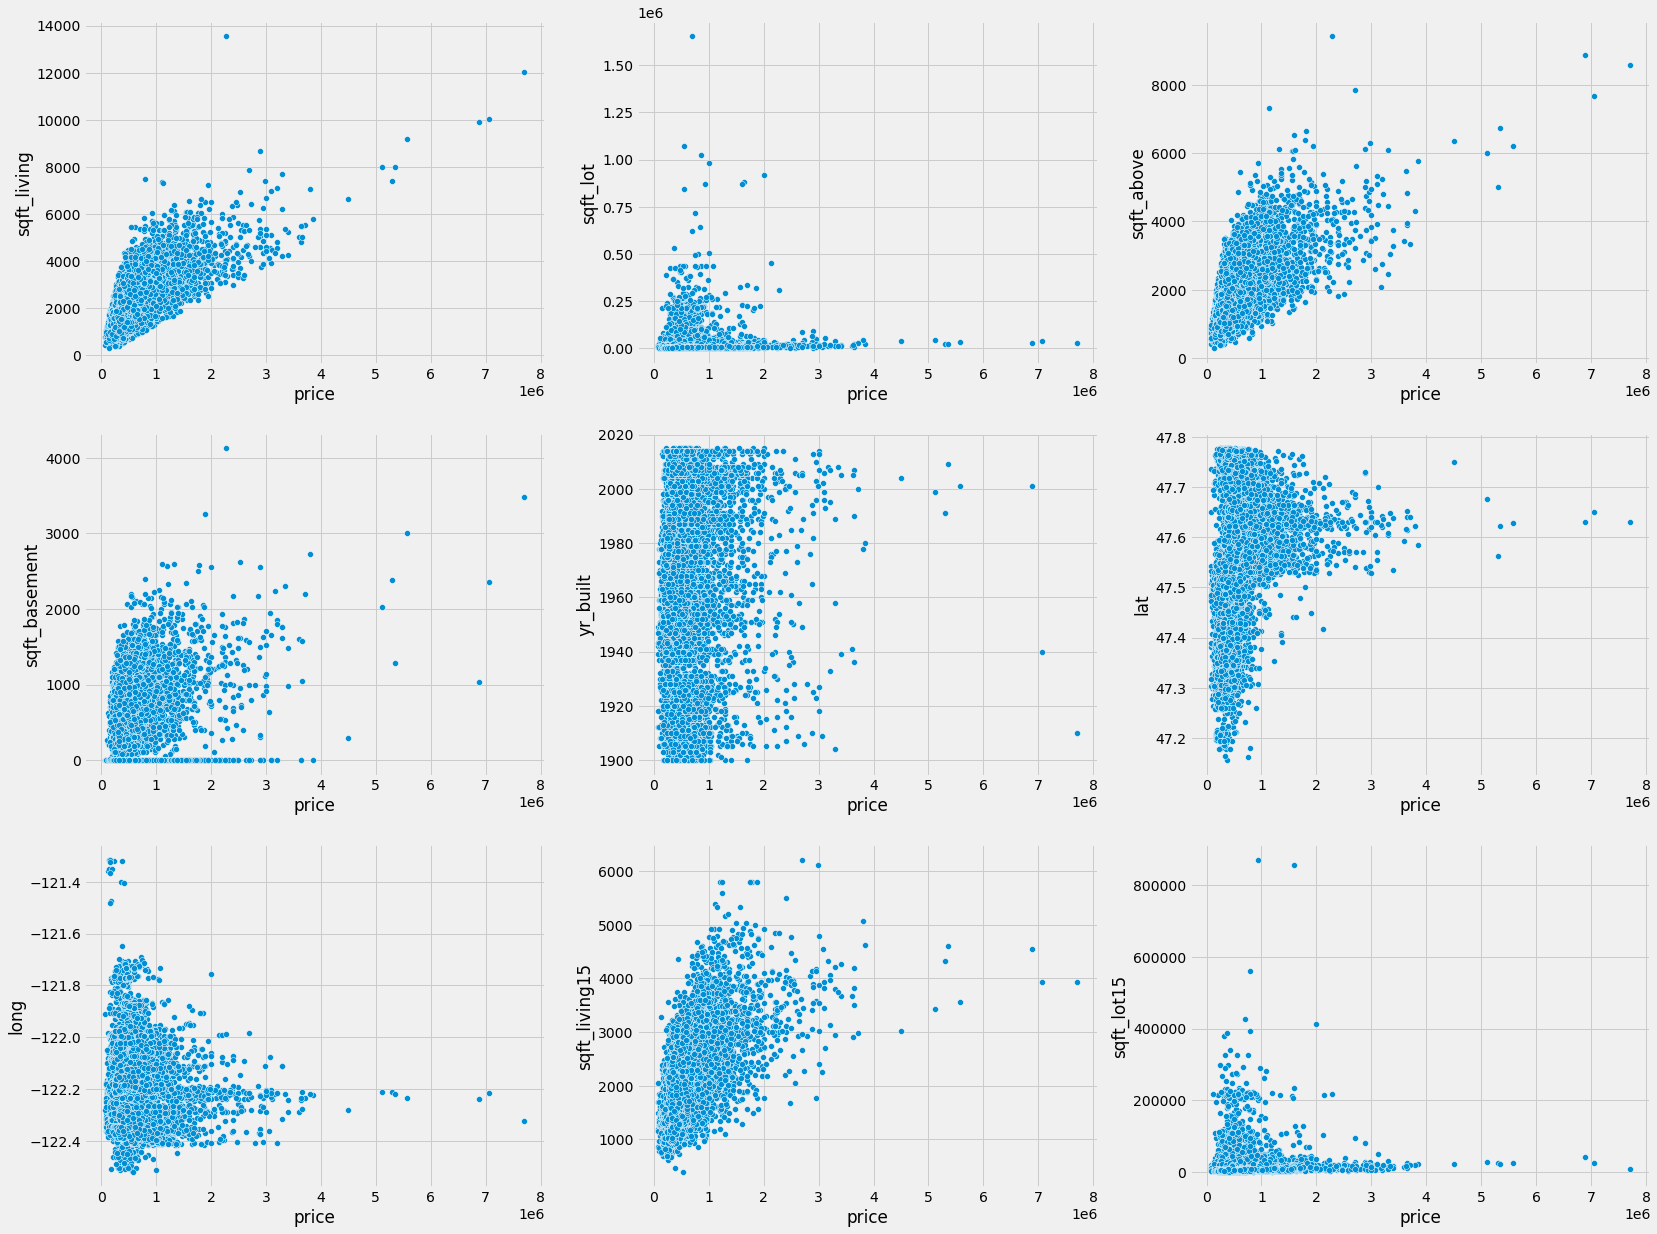

In [23]:
# y 값과 con_col 관계
fig, ax = plt.subplots(3, 3, figsize=(25, 20))
row = list(range(3))
col = list(range(3))
iters = product(row,col)
for col, i in zip(con_col, iters):
    sns.scatterplot(y = train[col], x=y, ax =ax[i[0]][i[1]])

In [24]:
# 지도 시각화
map_osm= folium.Map((47.6168, -122.257),zoom_start=9)
mc = MarkerCluster()

In [25]:
# 위도, 경도, 집코드만 가져옴
for_map=train[['lat','long','zipcode']].drop_duplicates(keep='first')
# 집 코드별 위경도로 묶음
for_map=for_map.groupby(['zipcode'])['lat','long'].mean()
for_map.reset_index(inplace=True)

In [26]:
for row in for_map.itertuples():
    mc.add_child(folium.Marker(location=[row.lat,  row.long], popup=row.zipcode)) #마커 생성
    map_osm.add_child(mc) 
    
map_osm

In [27]:
del map_osm

In [28]:
for_map2=train[['lat','long','zipcode']]
for_map2 = pd.concat([for_map2, y],axis=1)
for_map2.drop_duplicates(keep='first',inplace=True)

In [29]:
# 집 가격별로 구분지어보기 20% 40% 60% 80% 100%
_20 = for_map2['price'].quantile(q=0.2, interpolation='nearest')
_40 = for_map2['price'].quantile(q=0.4, interpolation='nearest')
_60 = for_map2['price'].quantile(q=0.6, interpolation='nearest')
_80 = for_map2['price'].quantile(q=0.8, interpolation='nearest')
_100 = for_map2['price'].max()
def func(x):
    if x <= _20:
        return 0
    elif x <= _40:
        return 1
    elif x <= _60:
        return 2
    elif x <= _80:
        return 3
    elif x <=_100:
        return 4
for_map2['region'] = for_map2['price'].apply(func)

In [30]:
for_map3 = for_map2.groupby(['zipcode'])['region','lat','long'].mean()

In [31]:
def func2(x):
    return round(x)
for_map3['region'] = for_map3['region'].map(func2)

In [32]:
for_map3=for_map3.reset_index()

In [33]:
map2= folium.Map((47.6168, -122.257),zoom_start=10)
# mc2 = MarkerCluster()

In [34]:
m_group = folium.FeatureGroup(name='regions')
map2.add_child(m_group)

for row in for_map3.itertuples():
    m_group.add_child(folium.Marker(location=[row.lat,  row.long], popup=row.zipcode))
    
group0 = FeatureGroupSubGroup(m_group,'region_0')
map2.add_child(group0)
for row in for_map3[for_map3['region']==0].itertuples():
    folium.Marker(location=[row.lat,  row.long], popup=row.zipcode, icon=folium.Icon(color='black')).add_to(group0)

group1 = FeatureGroupSubGroup(m_group,'region_1')
map2.add_child(group1)
for row in for_map3[for_map3['region']==1].itertuples():
    folium.Marker(location=[row.lat,  row.long], popup=row.zipcode, icon=folium.Icon(color='blue')).add_to(group1)

group2 = FeatureGroupSubGroup(m_group,'region_2')
map2.add_child(group2)
for row in for_map3[for_map3['region']==2].itertuples():
    folium.Marker(location=[row.lat,  row.long], popup=row.zipcode, icon=folium.Icon(color='green')).add_to(group2)

group3 = FeatureGroupSubGroup(m_group,'region_3')
map2.add_child(group3)
for row in for_map3[for_map3['region']==3].itertuples():
    folium.Marker(location=[row.lat,  row.long], popup=row.zipcode, icon=folium.Icon(color='purple')).add_to(group3)
    
group4 = FeatureGroupSubGroup(m_group,'region_4')
map2.add_child(group4)
for row in for_map3[for_map3['region']==4].itertuples():
    folium.Marker(location=[row.lat,  row.long], popup=row.zipcode, icon=folium.Icon(color='red')).add_to(group4)

In [35]:
map2

In [36]:
# train test zip code 중복 여부 확인
set(train['zipcode']) - set(test['zipcode']) 

set()

# Feature Engineering

In [37]:
# 지역을 위도와 경도로 격자를 만들어 구분 짓기
def geo_idx(dd, dd_array):
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

In [38]:
lon = np.linspace(total_data['long'].min(), total_data['long'].max(), 50)
lat = np.linspace(total_data['lat'].min(), total_data['lat'].max(), 50)

In [39]:
total_data['grid_lon'] = total_data['long'].map(lambda x: geo_idx(x, lon))
total_data['grid_lat'] = total_data['lat'].map(lambda x: geo_idx(x, lat))

In [40]:
total_data =pd.get_dummies(total_data, columns=['grid_lon','grid_lat'])

In [41]:
total_data.drop(['long','lat','date'],axis=1,inplace=True)

In [42]:
total_data.to_csv('./data/preprocessed_data.csv', index=False)
y.to_csv('./data/label.csv',index=False)

# EDA 정리
- Seattle 과 Bellvue 지역이 상대적으로 집 값이 비쌈
- Auborn 지역은 집 값이 싼지역
- 독립변수들 중 종속 변수에 뚜렷하게 큰 영향을 미치는 변수는 딱히 존재하지 않음
- 지역의 특성을 중요 변수로 사용함